In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Paths
BASE_DIR = Path(r'c:\Users\Acer\Desktop\Forex-Signal-App')
DATA_DIR = BASE_DIR / 'data'
MODEL_DIR = BASE_DIR / 'models' / 'signal_generator_v20'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Constants
TIMEFRAMES = ['15min', '30min', '1h', '4h'] 
FORWARD_BARS = 24          
ATR_PERIOD = 14
TP_ATR_MULT = 1.5          
SL_ATR_MULT = 1.0          

print(f"🚀 FOREX SIGNAL V20: Backtest Simulation & Trade Logging")
print(f"✓ Model Directory: {MODEL_DIR}")

🚀 FOREX SIGNAL V20: Backtest Simulation & Trade Logging
✓ Model Directory: c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v20


In [9]:
# 1. Load Data
def load_tf_data(timeframe, dataset_type='train'):
    filename = f'EURUSD_{timeframe}.csv'
    file_path = DATA_DIR / dataset_type / filename
        
    if not file_path.exists():
        print(f"⚠️ Warning: {file_path} not found.")
        return None
        
    df = pd.read_csv(file_path)
    df.columns = [c.lower() for c in df.columns]
    
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
    
    return df

timeframes_map = {
    '1min': 'm1',
    '5min': 'm5',
    '15min': 'm15',
    '30min': 'm30',
    '1h': 'h1',
    '4h': 'h4'
}

dfs_train = {}
dfs_test = {}

print("Loading TRAIN data...")
for tf_name, tf_code in timeframes_map.items():
    df = load_tf_data(tf_code, 'train')
    if df is not None:
        dfs_train[tf_name] = df

print("\nLoading TEST data...")
for tf_name, tf_code in timeframes_map.items():
    df = load_tf_data(tf_code, 'test')
    if df is not None:
        dfs_test[tf_name] = df

Loading TRAIN data...

Loading TEST data...


In [10]:
# 2. Feature Engineering (V19 Features)
def calculate_adx(df, period=14):
    df = df.copy()
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = (df['high'] - df['close'].shift(1)).abs()
    df['l-pc'] = (df['low'] - df['close'].shift(1)).abs()
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df['tr_smooth'] = df['tr'].rolling(window=period).mean()
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    df['dx'] = (abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di']) * 100)
    df['adx'] = df['dx'].rolling(window=period).mean()
    return df['adx']

def add_features(df):
    if df is None or len(df) == 0:
        return None
    df = df.copy()
    
    # ATR
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['atr'] = true_range.rolling(ATR_PERIOD).mean()
    
    # ADX
    df['adx'] = calculate_adx(df, 14)
    
    # Lags
    for lag in [1, 3, 5, 8, 13]:
        df[f'return_lag_{lag}'] = df['close'].pct_change(lag)
        
    # Volatility
    df['volatility_20'] = df['close'].pct_change().rolling(window=20).std()
    
    # EMAs
    for p in [20, 50, 200]:
        df[f'ema_{p}'] = df['close'].ewm(span=p, adjust=False).mean()
        df[f'dist_ema_{p}'] = (df['close'] - df[f'ema_{p}']) / df[f'ema_{p}']
        
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Time
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    return df.dropna()

print("Processing features...")
processed_train = {k: add_features(v) for k, v in dfs_train.items()}
processed_test = {k: add_features(v) for k, v in dfs_test.items()}
print("Done.")

Processing features...
Done.


In [11]:
# 3. Target Creation
def create_buy_target(df, tp_mult, sl_mult, forward_bars):
    targets = []
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry = closes[i]
        atr = atrs[i]
        
        if np.isnan(atr) or atr == 0:
            targets.append(0)
            continue
            
        tp = entry + (atr * tp_mult)
        sl = entry - (atr * sl_mult)
        
        outcome = 0 # 0 = WAIT/LOSS
        
        for j in range(1, forward_bars + 1):
            future_high = highs[i+j]
            future_low = lows[i+j]
            
            if future_low <= sl:
                outcome = 0
                break
            
            if future_high >= tp:
                outcome = 1 # BUY WIN
                break
                
        targets.append(outcome)
        
    targets.extend([0] * forward_bars)
    return np.array(targets)

print("Creating Targets...")
train_datasets = {}
test_datasets = {}

for tf, df in processed_train.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        train_datasets[tf] = df.iloc[:-FORWARD_BARS]

for tf, df in processed_test.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        test_datasets[tf] = df.iloc[:-FORWARD_BARS]

Creating Targets...


In [12]:
# 4. Train Models
models = {}
scalers = {}
feature_cols_dict = {}

for tf, df_train in train_datasets.items():
    print(f"\nTraining {tf}...")
    
    exclude_cols = ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume', 'atr', 
                    'h-l', 'h-pc', 'l-pc', 'tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm', 'tr_smooth', 'dx']
    
    cols = [c for c in df_train.columns if c not in exclude_cols]
    
    X_train = df_train[cols]
    y_train = df_train['target']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    model = xgb.XGBClassifier(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    models[tf] = model
    scalers[tf] = scaler
    feature_cols_dict[tf] = cols

print("\nTraining Complete.")


Training 1min...

Training 5min...

Training 15min...

Training 30min...

Training 1h...

Training 4h...

Training Complete.



==================== 1min PROBABILITY ANALYSIS ====================
Analyzing 377735 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%  377712   42.1620     2.6302   0.0000
    >=60%    7984   52.7305     0.3140   0.0000
    >=70%     252   64.2857     0.0319   0.0001
    >=80%      21   71.4286     0.0077   0.0004
    >=85%       0    0.0000     0.0000   0.0000
    >=90%       0    0.0000     0.0000   0.0000


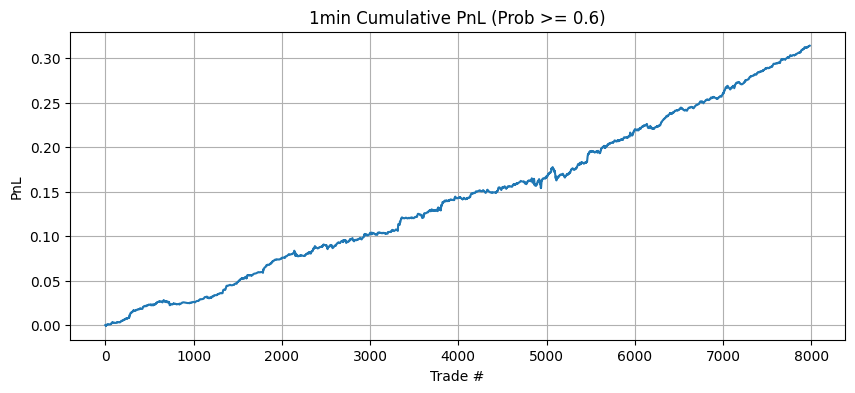


==================== 5min PROBABILITY ANALYSIS ====================
Analyzing 68451 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%   68432   41.0232     0.6281   0.0000
    >=60%    5507   48.3930     0.3629   0.0001
    >=70%     523   55.4493     0.0809   0.0002
    >=80%      30   93.3333     0.0312   0.0010
    >=85%      10  100.0000     0.0130   0.0013
    >=90%       0    0.0000     0.0000   0.0000


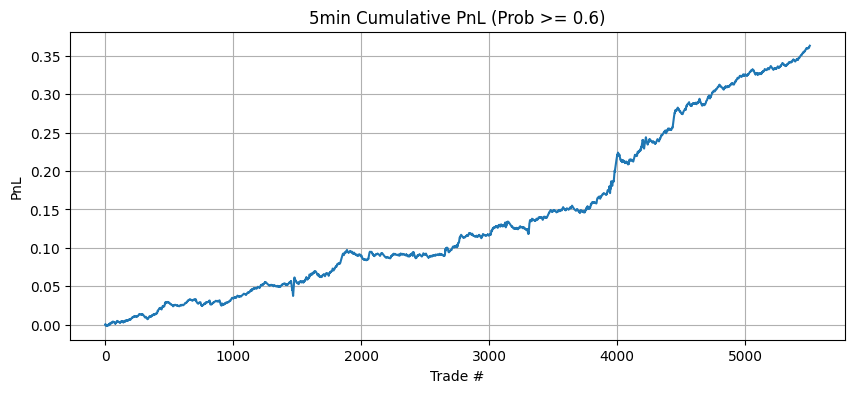


==================== 15min PROBABILITY ANALYSIS ====================
Analyzing 23736 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%   23725   39.6038     0.0127   0.0000
    >=60%    4265   40.5862     0.0816   0.0000
    >=70%     567   43.5626     0.0501   0.0001
    >=80%      18   50.0000     0.0038   0.0002
    >=85%       0    0.0000     0.0000   0.0000
    >=90%       0    0.0000     0.0000   0.0000


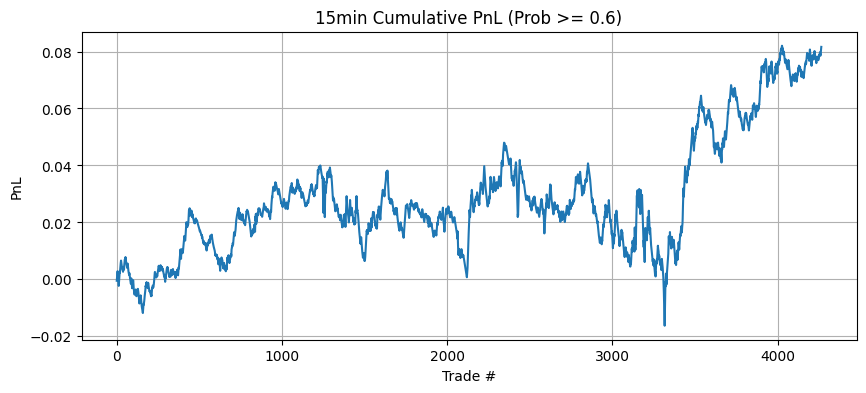


==================== 30min PROBABILITY ANALYSIS ====================
Analyzing 11477 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%   11461   39.3770     0.3394   0.0000
    >=60%    2812   39.6871     0.1363   0.0000
    >=70%     342   45.3216     0.0526   0.0002
    >=80%      29   44.8276     0.0108   0.0004
    >=85%       1    0.0000    -0.0007  -0.0007
    >=90%       0    0.0000     0.0000   0.0000


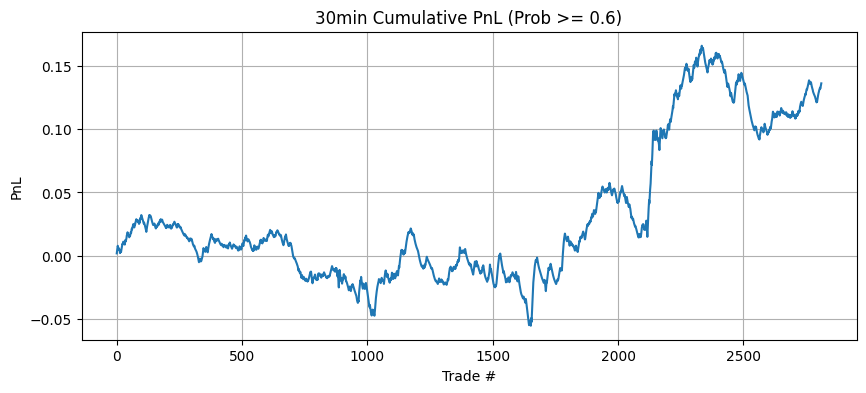


==================== 1h PROBABILITY ANALYSIS ====================
Analyzing 5934 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%    5914   38.5019    -0.1466  -0.0000
    >=60%    2203   37.9029    -0.1757  -0.0001
    >=70%     533   35.8349    -0.0885  -0.0002
    >=80%      51   17.6471    -0.0494  -0.0010
    >=85%      10    0.0000    -0.0164  -0.0016
    >=90%       0    0.0000     0.0000   0.0000


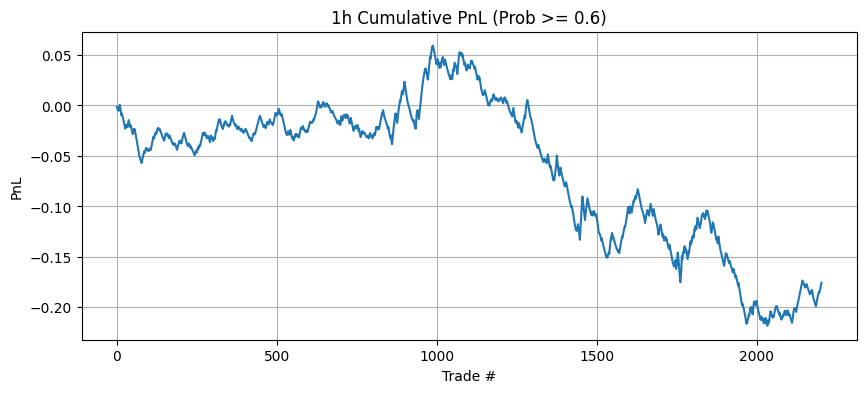


==================== 4h PROBABILITY ANALYSIS ====================
Analyzing 1401 potential setups (Prob > 0.5)...

Performance by Probability Threshold:
Threshold  Trades  Win Rate  Total PnL  Avg PnL
    >=50%    1388   41.7867     0.2467   0.0002
    >=60%     862   42.6914     0.1833   0.0002
    >=70%     475   42.7368     0.0943   0.0002
    >=80%     185   46.4865     0.0761   0.0004
    >=85%      65   49.2308     0.0264   0.0004
    >=90%      15   40.0000    -0.0031  -0.0002


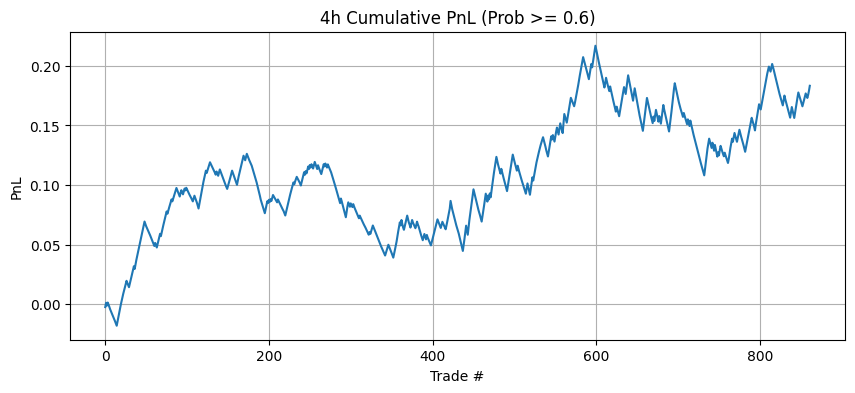

In [15]:
# 5. Backtest Simulation & Probability Analysis
def run_backtest_analysis(model, scaler, df, cols, tf_name):
    print(f"\n{'='*20} {tf_name} PROBABILITY ANALYSIS {'='*20}")
    
    # Prepare Data
    X = df[cols]
    X_scaled = scaler.transform(X)
    y_probs = model.predict_proba(X_scaled)[:, 1]
    
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    times = df.index
    
    # Pre-calculate outcomes for potential entries (Prob > 0.5)
    potential_trades = []
    min_threshold = 0.5
    indices = np.where(y_probs > min_threshold)[0]
    
    print(f"Analyzing {len(indices)} potential setups (Prob > 0.5)...")
    
    for i in indices:
        if i >= len(df) - FORWARD_BARS:
            continue
            
        entry_price = closes[i]
        atr = atrs[i]
        prob = y_probs[i]
        
        tp = entry_price + (atr * TP_ATR_MULT)
        sl = entry_price - (atr * SL_ATR_MULT)
        
        outcome = "HOLD"
        pnl = 0
        
        # Check future bars
        for j in range(1, FORWARD_BARS + 1):
            future_high = highs[i+j]
            future_low = lows[i+j]
            
            if future_low <= sl:
                outcome = "LOSS"
                pnl = sl - entry_price
                break
            
            if future_high >= tp:
                outcome = "WIN"
                pnl = tp - entry_price
                break
        
        if outcome == "HOLD":
            exit_price = closes[i+FORWARD_BARS]
            pnl = exit_price - entry_price
            outcome = "TIME_EXIT"
            
        potential_trades.append({
            'Prob': prob,
            'Result': outcome,
            'PnL': pnl
        })
    
    if not potential_trades:
        print("No trades found.")
        return

    df_trades = pd.DataFrame(potential_trades)
    
    # Analyze by Thresholds
    thresholds = [0.50, 0.60, 0.70, 0.80, 0.85, 0.90]
    results_data = []
    
    for thresh in thresholds:
        # Filter trades with Prob >= thresh
        subset = df_trades[df_trades['Prob'] >= thresh]
        
        if len(subset) == 0:
            results_data.append({
                'Threshold': f">={thresh*100:.0f}%",
                'Trades': 0,
                'Win Rate': 0.0,
                'Total PnL': 0.0,
                'Avg PnL': 0.0
            })
            continue
            
        wins = len(subset[subset['Result'] == 'WIN'])
        win_rate = (wins / len(subset)) * 100
        total_pnl = subset['PnL'].sum()
        avg_pnl = subset['PnL'].mean()
        
        results_data.append({
            'Threshold': f">={thresh*100:.0f}%",
            'Trades': len(subset),
            'Win Rate': win_rate,
            'Total PnL': total_pnl,
            'Avg PnL': avg_pnl
        })
    
    results_df = pd.DataFrame(results_data)
    print("\nPerformance by Probability Threshold:")
    print(results_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x) if isinstance(x, float) else f"{x}"))

    # Plot PnL for best threshold (e.g. 0.7 or 0.6)
    best_thresh = 0.6
    subset_best = df_trades[df_trades['Prob'] >= best_thresh].copy()
    if len(subset_best) > 0:
        subset_best['Cumulative PnL'] = subset_best['PnL'].cumsum()
        plt.figure(figsize=(10, 4))
        plt.plot(subset_best['Cumulative PnL'].values)
        plt.title(f'{tf_name} Cumulative PnL (Prob >= {best_thresh})')
        plt.xlabel('Trade #')
        plt.ylabel('PnL')
        plt.grid(True)
        plt.show()

# Run Analysis
for tf, df_test in test_datasets.items():
    if tf in models:
        run_backtest_analysis(models[tf], scalers[tf], df_test, feature_cols_dict[tf], tf)

In [14]:
# 6. Save Models
joblib.dump(models, MODEL_DIR / 'models_dict_v20.joblib')
joblib.dump(scalers, MODEL_DIR / 'scalers_dict_v20.joblib')
joblib.dump(feature_cols_dict, MODEL_DIR / 'feature_cols_dict_v20.joblib')
print("V20 Models saved.")

V20 Models saved.
